In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# """
# zhihu: https://zhuanlan.zhihu.com/p/94757947
# Github: Yonv1943 Zen4 Jia1 hao2
# https://github.com/Yonv1943/DL_RL_Zoo/blob/master/RNN
# The source of training data 
# https://github.com/L1aoXingyu/
# code-of-learn-deep-learning-with-pytorch/blob/master/
# chapter5_RNN/time-series/lstm-time-series.ipynb
# """

## Dataset

In [3]:
def load_data():
    # passengers number of international airline , 1949-01 ~ 1960-12 per month
    seq_number = np.array(
        [112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
         118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
         114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
         162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
         209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
         272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
         302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
         315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
         318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
         348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
         362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
         342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
         417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
         432.], dtype=np.float32)
    # assert seq_number.shape == (144, )
    # plt.plot(seq_number)
    # plt.ion()
    # plt.pause(1)
    seq_number = seq_number[:, np.newaxis]

    # print(repr(seq))
    # 1949~1960, 12 years, 12*12==144 month
    seq_year = np.arange(12)
    seq_month = np.arange(12)
    seq_year_month = np.transpose(
        [np.repeat(seq_year, len(seq_month)),
         np.tile(seq_month, len(seq_year))],
    )  # Cartesian Product

    seq = np.concatenate((seq_number, seq_year_month), axis=1)

    # normalization
    seq = (seq - seq.mean(axis=0)) / seq.std(axis=0)
    return seq

In [4]:
x = load_data()
x[0]

array([-1.40777884, -1.59325501, -1.59325501])

## LSTM

In [5]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y
    

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc

## Training

如果batch_size设为1，并依次送到LSTM中训练，其效果如下所示：

+ 使用第(107,)月份的数据预测第108个月的客流量;
+ 使用第 (106, 107) -> (107, 108); 
    + 因为RNN架构的性质，在预测第107个月的客流量时只用了第106个月的数据；在预测第108个月的客流量时，第107个月的数据是直接输入到当前预测网络中的，而且第106个月的信息也会随着h,c被考虑到，因此可以说第108个月的预测值是考虑了第106、107个月的数据
+ 使用第 (105, 106, 107) -> (106, 107, 108);
+ 使用第 (104, 105, 106, 107) -> (105, 106, 107, 108);
+ ...
+ 使用第 (62, ..., 106, 107) -> (63, ..., 107, 108);

In [24]:
def run_train_lstm():
    inp_dim = 3
    out_dim = 1
    mid_dim = 8
    mid_layers = 1
    batch_size = 12 * 4
    mod_dir = '.'

    '''load data'''
    data = load_data()
    data_x = data[:-1, :]  # (143, 3)
    data_y = data[+1:, 0]  # (143, )
    print(data_x.shape)
    assert data_x.shape[1] == inp_dim

    train_size = int(len(data_x) * 0.75)  # 108

    train_x = data_x[:train_size]
    train_y = data_y[:train_size]
    train_y = train_y.reshape((train_size, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)  # (108, 3)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)  # (108,)

    batch_var_x = list()
    batch_var_y = list()

    for i in range(batch_size):
        j = train_size - i  # 108 - 0, 108 - 1, 108 - 2, ..., 108 - 47
        batch_var_x.append(var_x[j:])  #[(0, 3), (1, 3), (2, 3), ..., (47, 3)]
        # print(var_x[j:].shape)
        batch_var_y.append(var_y[j:])  #[(0, ), (1, ), (2, ), ..., (47, )]

    from torch.nn.utils.rnn import pad_sequence
    batch_var_x = pad_sequence(batch_var_x)  # (47, 48, 3) / (seq_len, batch_size, feat_dim) / (一个句子包含的单词个数, 一次送进去多少个句子, 每个单词用多少维度的向量表示) / 对那些不足47个单词的句子进行补零
    batch_var_y = pad_sequence(batch_var_y)  # ()

    with torch.no_grad():
        weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
        weights = torch.tensor(weights, dtype=torch.float32, device=device)

    print("Training Start")
    for e in range(60):
        out = net(batch_var_x)
    
        # loss = criterion(out, batch_var_y)
        loss = (out - batch_var_y) ** 2 * weights
        loss = loss.mean()
    
        optimizer.zero_grad()
        loss.backward()  
        optimizer.step()
    
        if e % 64 == 0:
            print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
    torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
    print("Save in:", '{}/net.pth'.format(mod_dir))

    '''eval'''
    net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
    net = net.eval()

    test_x = data_x.copy()
    test_x[train_size:, 0] = 0
    test_x = test_x[:, np.newaxis, :]
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

    '''elegant way but slightly complicated'''
    eval_size = 1
    zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32, device=device)
    test_y, hc = net.output_y_hc(test_x[:train_size], (zero_ten, zero_ten))
    print(test_x.shape)
    test_x[train_size + 1, 0, 0] = test_y[-1]
    for i in range(train_size + 1, len(data_x) - 1):
        test_y, hc = net.output_y_hc(test_x[i:i + 1], hc)
        test_x[i + 1, 0, 0] = test_y[-1]
    pred_y = test_x[1:, 0, 0]
    pred_y = pred_y.cpu().data.numpy()

    diff_y = pred_y[train_size:] - data_y[train_size:-1]
    l1_loss = np.mean(np.abs(diff_y))
    l2_loss = np.mean(diff_y ** 2)
    print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))
    
    fig = plt.figure(figsize=[12, 6])
    plt.plot(pred_y, 'r', label='pred', linewidth=5, alpha=0.5)
    plt.plot(data_y, 'g', label='real', alpha=0.5)
    plt.plot([train_size, train_size], [-1, 2], color='k', label='train | pred')
    plt.legend(loc='best')
    plt.savefig('lstm_reg.png')
    plt.pause(4)

(143, 3)
Training Start
Epoch:    0, Loss: 0.20691
Save in: ./net.pth
torch.Size([143, 1, 3])
L1: 0.481    L2: 0.352


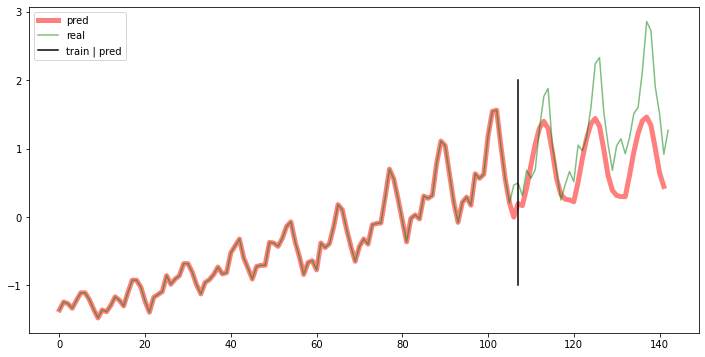

In [25]:
run_train_lstm()

## GRU

In [8]:
class RegGRU(nn.Module):
    def __init__(self, inp_dim, out_dim, mod_dim, mid_layers):
        super(RegGRU, self).__init__()

        self.rnn = nn.GRU(inp_dim, mod_dim, mid_layers)
        self.reg = nn.Linear(mod_dim, out_dim)

    def forward(self, x):
        x, h = self.rnn(x)  # (seq, batch, hidden)

        seq_len, batch_size, hid_dim = x.shape
        x = x.view(-1, hid_dim)
        x = self.reg(x)
        x = x.view(seq_len, batch_size, -1)
        return x

    def output_y_h(self, x, h):
        y, h = self.rnn(x, h)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, h

## Training

In [14]:
def run_train_gru():
    inp_dim = 3
    out_dim = 1
    batch_size = 12 * 4

    '''load data'''
    data = load_data()
    print(data.shape)
    data_x = data[:-1, :]
    data_y = data[+1:, 0]
    assert data_x.shape[1] == inp_dim

    train_size = int(len(data_x) * 0.75)

    train_x = data_x[:train_size]
    train_y = data_y[:train_size]
    train_x = train_x.reshape((train_size, inp_dim))
    train_y = train_y.reshape((train_size, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegGRU(inp_dim, out_dim, mod_dim=12, mid_layers=2).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

    batch_var_x = list()
    batch_var_y = list()

    for i in range(batch_size):
        j = train_size - i
        batch_var_x.append(var_x[j:])
        batch_var_y.append(var_y[j:])

    from torch.nn.utils.rnn import pad_sequence
    batch_var_x = pad_sequence(batch_var_x)
    batch_var_y = pad_sequence(batch_var_y)

    with torch.no_grad():
        weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
        weights = torch.tensor(weights, dtype=torch.float32, device=device)

    for e in range(256):
        out = net(batch_var_x)

        # loss = criterion(out, batch_var_y)
        loss = (out - batch_var_y) ** 2 * weights
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 100 == 0:
            print('Epoch: {}, Loss: {:.5f}'.format(e, loss.item()))

    '''eval'''
    net = net.eval()

    test_x = data_x.copy()
    test_x[train_size:, 0] = 0
    test_x = test_x[:, np.newaxis, :]
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
    for i in range(train_size, len(data) - 2):
        test_y = net(test_x[:i])
        test_x[i + 1, 0, 0] = test_y[-1]
    pred_y = test_x[1:, 0, 0]
    pred_y = pred_y.cpu().data.numpy()

    diff_y = pred_y[train_size:] - data_y[train_size:-1]
    l1_loss = np.mean(np.abs(diff_y))
    l2_loss = np.mean(diff_y ** 2)
    print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))
    plt.plot(pred_y, 'r', label='pred')
    plt.plot(data_y, 'b', label='real')
    plt.legend(loc='best')
    plt.pause(4)

**LSTM + SmoothL1Loss + larger epoch**

+ 使用第((1, 2), (2, 3), (3, 4), ..., (106, 107))份的数据预测第(3, 4, 5, ..., 108)个月的客流量;

In [15]:
def run_origin():
    inp_dim = 2
    out_dim = 1
    mod_dir = '.'

    '''load data'''
    data = load_data()  # axis1: number, year, month
    print(data.shape)
    data_x = np.concatenate((data[:-2, 0:1], data[1:-1, 0:1]), axis=1)
    data_y = data[2:, 0]

    train_size = int(len(data_x) * 0.75)
    train_x = data_x[:train_size]
    train_y = data_y[:train_size]

    train_x = train_x.reshape((-1, 1, inp_dim))  # (106, 1, 2) / (seq_len, batch_size, feat_dim) / 总是用前两个月的客流量去预测后一个月的客流量
    train_y = train_y.reshape((-1, 1, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegLSTM(inp_dim, out_dim, mid_dim=4, mid_layers=2).to(device)
    criterion = nn.SmoothL1Loss()  
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)
    print('var_x.size():', var_x.size())
    print('var_y.size():', var_y.size())

    for e in range(512):
        out = net(var_x)
        loss = criterion(out, var_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (e + 1) % 100 == 0:  # 每 100 次输出结果
            print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

    torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))

    '''eval'''
    # net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
    net = net.eval()  # 转换成测试模式

    """
    inappropriate way of seq prediction: 
    use all real data to predict the number of next month
    """
    test_x = data_x.reshape((-1, 1, inp_dim))
    var_data = torch.tensor(test_x, dtype=torch.float32, device=device)
    eval_y = net(var_data)  # 测试集的预测结果
    pred_y = eval_y.view(-1).cpu().data.numpy()

    plt.plot(pred_y[1:], 'r', label='pred inappr', alpha=0.3)
    plt.plot(data_y, 'b', label='real', alpha=0.3)
    plt.plot([train_size, train_size], [-1, 2], label='train | pred')

    """
    appropriate way of seq prediction: 
    use real+pred data to predict the number of next 3 years.
    """
    test_x = data_x.reshape((-1, 1, inp_dim))
    test_x[train_size:] = 0  # delete the data of next 3 years.
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
    for i in range(train_size, len(data) - 2):
        test_y = net(test_x[:i])
        test_x[i, 0, 0] = test_x[i - 1, 0, 1]
        test_x[i, 0, 1] = test_y[-1, 0]
    pred_y = test_x.cpu().data.numpy()
    pred_y = pred_y[:, 0, 0]
    plt.plot(pred_y[2:], 'g', label='pred appr')

    plt.legend(loc='best')
    plt.savefig('lstm_origin.png')
    plt.show()
    plt.pause(4)

(144, 3)
var_x.size(): torch.Size([106, 1, 2])
var_y.size(): torch.Size([106, 1, 1])
Epoch: 100, Loss: 0.03682
Epoch: 200, Loss: 0.01445
Epoch: 300, Loss: 0.01172
Epoch: 400, Loss: 0.00957
Epoch: 500, Loss: 0.00829


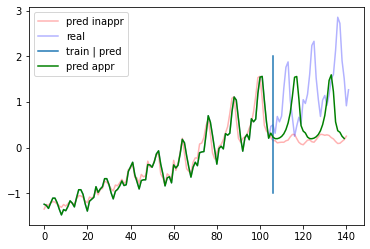

In [16]:
if __name__ == '__main__':
    # run_train_lstm()
    # run_train_gru()
    run_origin()